# PySpark Machine Learning Demo

## Overview of the Predictive Modeling Case

A financial services company offers a home equity line of credit to its clients. The
company has extended several thousand lines of credit in the past, and many of these
accepted applicants (approximately 20%) have defaulted on their loans. By using
geographic, demographic, and financial variables, the company wants to build a model
to predict whether an applicant will default.

## Loading packages

In [1]:
# Imports the connection information

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from operator import itemgetter
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.feature import Imputer, StandardScaler, VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession, DataFrame, Column
import pyspark.sql.functions as F
import time

## Initializing session

In [2]:
# Creates the Spark Session

spark = SparkSession.builder.appName("ml_comparison").getOrCreate()

## Loading data into memory

In [3]:
# Reads the CSV into memory

hmeq = spark.read.csv("hmeq.csv", header = True, inferSchema = True)

In [4]:
# Displays the type of the object

type(hmeq)

pyspark.sql.dataframe.DataFrame

In [5]:
# Displays a sample of the rows in the dataframe

hmeq.head(n = 5)

[Row(BAD=1, LOAN=1100, MORTDUE=25860.0, VALUE=39025.0, REASON='HomeImp', JOB='Other', YOJ=10.5, DEROG=0, DELINQ=0, CLAGE=94.3666666666667, NINQ=1, CLNO=9, DEBTINC=None),
 Row(BAD=1, LOAN=1300, MORTDUE=70053.0, VALUE=68400.0, REASON='HomeImp', JOB='Other', YOJ=7.0, DEROG=0, DELINQ=2, CLAGE=121.833333333333, NINQ=0, CLNO=14, DEBTINC=None),
 Row(BAD=1, LOAN=1500, MORTDUE=13500.0, VALUE=16700.0, REASON='HomeImp', JOB='Other', YOJ=4.0, DEROG=0, DELINQ=0, CLAGE=149.466666666667, NINQ=1, CLNO=10, DEBTINC=None),
 Row(BAD=1, LOAN=1500, MORTDUE=None, VALUE=None, REASON=None, JOB=None, YOJ=None, DEROG=None, DELINQ=None, CLAGE=None, NINQ=None, CLNO=None, DEBTINC=None),
 Row(BAD=0, LOAN=1700, MORTDUE=97800.0, VALUE=112000.0, REASON='HomeImp', JOB='Office', YOJ=3.0, DEROG=0, DELINQ=0, CLAGE=93.3333333333333, NINQ=0, CLNO=14, DEBTINC=None)]

In [6]:
# Displays the available columns in the dataset

print("Object type is", str(type(hmeq.columns)))
hmeq.columns

Object type is <class 'list'>


['BAD',
 'LOAN',
 'MORTDUE',
 'VALUE',
 'REASON',
 'JOB',
 'YOJ',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC']

In [7]:
# Display shape of the dataset

print("This table has", str(hmeq.count()), "rows and", str(len(hmeq.columns)), "columns")

This table has 5960 rows and 13 columns


## Data exploration

In [8]:
# Display a summary of the table

hmeq.printSchema()

root
 |-- BAD: integer (nullable = true)
 |-- LOAN: integer (nullable = true)
 |-- MORTDUE: double (nullable = true)
 |-- VALUE: double (nullable = true)
 |-- REASON: string (nullable = true)
 |-- JOB: string (nullable = true)
 |-- YOJ: double (nullable = true)
 |-- DEROG: integer (nullable = true)
 |-- DELINQ: integer (nullable = true)
 |-- CLAGE: double (nullable = true)
 |-- NINQ: integer (nullable = true)
 |-- CLNO: integer (nullable = true)
 |-- DEBTINC: double (nullable = true)



In [9]:
# Displays the column types

hmeq.dtypes

[('BAD', 'int'),
 ('LOAN', 'int'),
 ('MORTDUE', 'double'),
 ('VALUE', 'double'),
 ('REASON', 'string'),
 ('JOB', 'string'),
 ('YOJ', 'double'),
 ('DEROG', 'int'),
 ('DELINQ', 'int'),
 ('CLAGE', 'double'),
 ('NINQ', 'int'),
 ('CLNO', 'int'),
 ('DEBTINC', 'double')]

In [10]:
# Displaytype of target variable info

type(hmeq["BAD"])

pyspark.sql.column.Column

In [11]:
# Displays target variable distribution

target_dist = hmeq.groupby("BAD").count()
target_dist = target_dist.withColumn("percentage", F.round(target_dist["count"]*100/hmeq.count(), 3))
target_dist.show()

+---+-----+----------+
|BAD|count|percentage|
+---+-----+----------+
|  1| 1189|     19.95|
|  0| 4771|     80.05|
+---+-----+----------+



In [12]:
# Search for duplicate rows

hmeq.dropDuplicates().count()

5960

In [13]:
# Filters missing values

missing = {col: hmeq.filter(hmeq[col].isNull()).count() for col in hmeq.columns}

# Creates a dataframe

missing_df = pd.DataFrame.from_dict(missing, orient = "index", columns = ["nmiss_count"])
missing_df = missing_df.reset_index(names = ["column"])
missing_df["nmiss_pct"] = missing_df["nmiss_count"]*100/hmeq.count()

missing_df

,column,nmiss_count,nmiss_pct
0,BAD,0,0.000000
1,LOAN,0,0.000000
2,MORTDUE,518,8.691275
3,VALUE,112,1.879195
4,REASON,252,4.228188
5,JOB,279,4.681208
6,YOJ,515,8.640940
7,DEROG,708,11.879195
8,DELINQ,580,9.731544
9,CLAGE,308,5.167785


[Text(0, 0.0, '0%'),
 Text(0, 2.5, '2%'),
 Text(0, 5.0, '5%'),
 Text(0, 7.5, '8%'),
 Text(0, 10.0, '10%'),
 Text(0, 12.5, '12%'),
 Text(0, 15.0, '15%'),
 Text(0, 17.5, '18%'),
 Text(0, 20.0, '20%'),
 Text(0, 22.5, '22%')]

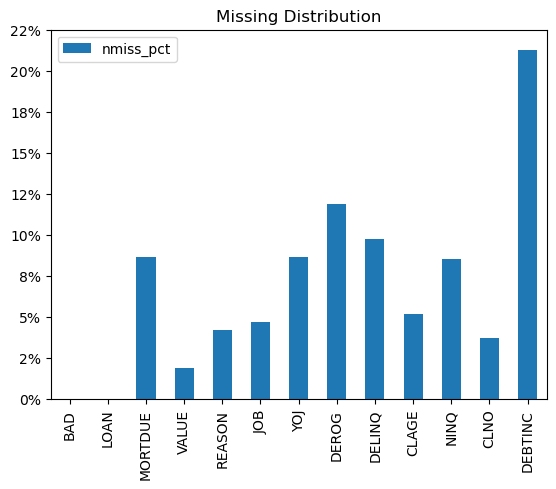

In [14]:
# Plots missing values

ax = missing_df.plot(x = "column", y = "nmiss_pct", xlabel = "", kind = "bar", title = "Missing Distribution")
y_vals = ax.get_yticks().tolist()
ax.set_yticks(y_vals)
ax.set_yticklabels(["{:.0f}%".format(i) for i in y_vals])

In [15]:
# Creates lists of the different variable types

ints = [i[0] for i in hmeq.dtypes if i[1] == "int"]
doubles = [i[0] for i in hmeq.dtypes if i[1] == "double"]
strings = [i[0] for i in hmeq.dtypes if i[1] == "string"]

In [16]:
# Display distribution of the different variable types

print("INTEGERS", end="\n")
hmeq.describe(ints).show()

print("DOUBLES", end="\n")
hmeq.describe(doubles).show()

print("STRINGS", end="\n")
hmeq.describe(strings).show()

INTEGERS
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|              BAD|              LOAN|             DEROG|            DELINQ|              NINQ|              CLNO|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|             5960|              5960|              5252|              5380|              5450|              5738|
|   mean|0.199496644295302| 18607.96979865772|0.2545696877380046|0.4494423791821561|1.1860550458715597| 21.29609620076682|
| stddev|0.399655517450269|11207.480416693992| 0.846046777086318|1.1272659176049744|1.7286749712080534|10.138933192458637|
|    min|                0|              1100|                 0|                 0|                 0|                 0|
|    max|                1|             89900|                10|                15|                17|                71|
+------

In [ ]:
# # Creates a pandas.DataFrame copy of HMEQ 

# hmeq_df = hmeq.toPandas()

In [ ]:
# # Changes matplotlib parameters

# plt.tight_layout()

# # Plots histograms

# hmeq_df.hist(figsize = (12,12))

In [18]:
# Creates a list of all non-string variables and no target variable

nums = ints[1:] + doubles

# Creates a list of the variables to be imputed by mode and mean

median = ["YOJ", "DEROG", "NINQ", "DELINQ"]
mean = [i for i in nums if i not in median]

In [24]:
# Displays the distribution of the string variables

print("REASON frequency table", end="\n")
reason_freq = hmeq.groupby("REASON").count().show()

print("JOB frequency table", end="\n")
job_freq = hmeq.groupby("JOB").count().show()

REASON frequency table
+-------+-----+
| REASON|count|
+-------+-----+
|HomeImp| 1780|
|   NULL|  252|
|DebtCon| 3928|
+-------+-----+

JOB frequency table
+-------+-----+
|    JOB|count|
+-------+-----+
|  Sales|  109|
| Office|  948|
|ProfExe| 1276|
|   NULL|  279|
|   Self|  193|
|  Other| 2388|
|    Mgr|  767|
+-------+-----+



In [ ]:
# # Prepares an assembler to vectorize the dataframe

# assembler = VectorAssembler(inputCols = nums, outputCol = "features")

# # Transforms the hmeq dataframe into vector form and removes rows that contain na from the analysis

# vector_nums = assembler.transform(hmeq.dropna())
# corr_matrix = Correlation.corr(vector_nums, "features").collect()

In [ ]:
# # Turns the correlation matrix into a numpy array

# corr_arr = corr_matrix[0][0].toArray()
# corr_df = pd.DataFrame(corr_arr, columns = nums, index = nums)

In [ ]:
# # Generates a heatmap using the correlation values

# fig, ax = plt.subplots(figsize = (10,10))
# cmap = plt.get_cmap("coolwarm").reversed()
# corr_plot = sns.heatmap(corr_df, vmin = -1, vmax = 1, annot=True, cmap=cmap)
# corr_plot.set_title("Correlation HeatMap")

## Data pre-processing and partitioning

In [25]:
# Map categorical values to numeric values

def cat_mapper(df, columns, inplace = False):
    """
    Searches through the specified categorical columns and maps their values to integers that represent categories.

    parameters
    ----------
    df: DataFrame. Contains the columns that need to be remapped.
    columns: List. Contains the name of the columns to be remapped.
    """

    # Performs basic type checking
    
    if isinstance(df, DataFrame) == False:
        raise(TypeError("The df parameter must be an instance of a PySpark DataFrame."))

    if isinstance(columns, list) == False:
        raise(TypeError("The columns parameter must be list containing the name of the columns that will be mapped."))

    # Remaps the specified categorical columns 

    all_maps = []
    
    for col in columns:
        # Creates a dictionary of the categories and enumerates them 
        distinct_rows = df.select(col).distinct().collect()
        categories = [(i, col[0]) for i, col in enumerate(distinct_rows) if col[0] is not None]
        cat_map = {i[1]: i[0] for i in categories}
        
        # Appends the mapping for the current column into a list
        all_maps.append(cat_map)

        # Creates a map using the previously created dictionary and then applies the mapping to the corresponding column
        mapping_expr = F.create_map(*[F.lit(x) for x in chain(*cat_map.items())])
        df = df.withColumn(col + "_MAPPED", mapping_expr[F.col(col)]) 
            
    return df, all_maps    

In [26]:
# Applies the mapping function to get a new column that contains the mapped values 

hmeq, hmeq_map = cat_mapper(hmeq, strings)

In [27]:
# Displays the new columns and their corresponding mapped versions

hmeq.select(["REASON", "REASON_MAPPED"]).distinct().show()
hmeq.select(["JOB", "JOB_MAPPED"]).distinct().show()

+-------+-------------+
| REASON|REASON_MAPPED|
+-------+-------------+
|HomeImp|            0|
|DebtCon|            1|
|   NULL|         NULL|
+-------+-------------+

+-------+----------+
|    JOB|JOB_MAPPED|
+-------+----------+
|ProfExe|         2|
|  Other|         4|
|  Sales|         0|
|    Mgr|         5|
| Office|         1|
|   Self|         3|
|   NULL|      NULL|
+-------+----------+



In [28]:
# Defines a function to perform stratified sampling

def train_test_split(df, train_pct, target, samp_type = "random", seed = 42):
    """
    Defines a function to have more control on paritioning data for training and validation.
    This only works on binary columns with target values of 0 and 1.
    
    Parameters
    ----------

    df: PySpark DataFrame that will be partitioned.

    train_pct: Percentage of the data that will belong to training.

    target: String representing the target column name.

    samp_type: random, stratified. The type of sampling to be performed.

    seed: Integer that represents the random seed. Default = 42.
    """

    # Checks input types
    
    if isinstance(df, DataFrame) == False:
        raise(TypeError("df parameter is not of PySpark DataFrame type."))

    if isinstance(target, str) == False:
            raise(TypeError("target parameter is not a str type."))
        
    if isinstance(samp_type, str) == False:
        raise(TypeError("samp_type parameter not a string."))

    if isinstance(seed, int) == False:
        raise(TypeError("seed parameter not an int."))

    # Checks for valid values

    if samp_type not in ["random", "stratify"]:
        raise(ValueError("samp_type only supports values of random or stratify."))
        
    if train_pct < 0 or train_pct > 1:
        raise(ValueError("train_pct must be a float between 0 and 1."))

    # Applies random sampling

    if samp_type == "random":
        train, test = df.randomSplit([train_pct, test_pct], seed = seed)

    if samp_type == "stratify":        
        # Performs stratified sampling and returns the proportion of rows specified by the train_pct option 
        train = df.sampleBy(target, {0: train_pct, 1: train_pct}, seed).limit(round(train_pct*df.count()))
        test = df.exceptAll(train)

    df_list = [train, test]
    
    return df_list

In [29]:
# Partitions the dataset into training and validation

train, test = train_test_split(hmeq, 0.7, "BAD", samp_type = "stratify")

In [30]:
# Displays some quick chekcs to ensure the data was partitioned correctly

print("The training partition contains", str(train.count()/hmeq.count()) + "%", "of the rows.", end = "\n\n" )
print("The testing partition contains", str(test.count()/hmeq.count()) + "%", "of the rows.", end="\n\n")

print("Target Distribution in Training:", end = "\n\n")
train_bad_dist = train.groupBy("BAD").count()
train_bad_dist.withColumn("Percentage", F.round(train_bad_dist["count"]/train.count(), 2)).show()

print("Target Distribution in Testing:", end = "\n\n")
test_bad_dist = test.groupBy("BAD").count()
test_bad_dist.withColumn("Percentage", F.round(test_bad_dist["count"]/test.count(), 2)).show()

The training partition contains 0.7% of the rows.

The testing partition contains 0.3% of the rows.

Target Distribution in Training:

+---+-----+----------+
|BAD|count|Percentage|
+---+-----+----------+
|  1|  830|       0.2|
|  0| 3342|       0.8|
+---+-----+----------+

Target Distribution in Testing:

+---+-----+----------+
|BAD|count|Percentage|
+---+-----+----------+
|  1|  359|       0.2|
|  0| 1429|       0.8|
+---+-----+----------+



In [31]:
# Creates a new list containing these new columns to impute them with their mode

mode = ["REASON_MAPPED", "JOB_MAPPED"]

In [80]:
# Creates a list of the output column names 

mean_out = ["{}_OUT".format(i) for i in mean]
median_out = ["{}_OUT".format(i) for i in median]
mode_out = ["{}_OUT".format(i) for i in mode]

In [81]:
# Creates a mean, median, and mode imputer type objects

mean_imputer = Imputer(strategy = "mean", inputCols = mean, outputCols = mean_out) 
median_imputer = Imputer(strategy = "median", inputCols = median, outputCols = median_out)
mode_imputer = Imputer(strategy = "mode", inputCols = mode, outputCols = mode_out)

In [82]:
# Dummy for testing

dummy = hmeq

In [83]:
# Fits the imputers

mi = mean_imputer.fit(train)
mei = median_imputer.fit(train)
moi = mode_imputer.fit(train)

# Transforms the datasets by applying the imputers

dummy = mi.transform(dummy)
dummy = mei.transform(dummy)
dummy = moi.transform(dummy)

In [84]:
# Checks to ensure all missing values are replaced

_missing = {}
all_vars = mean_out + median_out + mode_out

for i in all_vars:
    _missing.update({i: dummy.filter(dummy[i].isNull()).count()})

_missing

{'LOAN_OUT': 0,
 'CLNO_OUT': 0,
 'MORTDUE_OUT': 0,
 'VALUE_OUT': 0,
 'CLAGE_OUT': 0,
 'DEBTINC_OUT': 0,
 'YOJ_OUT': 0,
 'DEROG_OUT': 0,
 'NINQ_OUT': 0,
 'DELINQ_OUT': 0,
 'REASON_MAPPED_OUT': 0,
 'JOB_MAPPED_OUT': 0}

In [85]:
# Defines a dummy coder

def dummy_coder(df, cols):
    """
    Defines a function to dummy code categorical columns.
    Returns a column for each category where the suffix is the value
    that the column represents.
    
    Parameters
    ----------

    df: PySpark DataFrame that will be partitioned.

    cols: List containing the names of the categorical columns to be dummy coded.
    """

    # Checks input types
    
    if isinstance(df, DataFrame) == False:
        raise(TypeError("df parameter is not of PySpark DataFrame type."))

    if isinstance(cols, list) == False:
            raise(TypeError("cols parameter is not of list type."))

    # Creates an empty dictionary and iterates through columns

    _map = {}
    _cols = []
    
    for i in cols:
        # Gets a list of the distinct values
        distinct_list = df.select(i).distinct().sort(i).collect()
        for j in distinct_list:
            # Selects the row element value and creates the name of the column to be created
            j = j[0]
            col_name = "{i}_{j}".format(i = i, j = j)
            
            # Stores column names and creates a map  
            _cols.append(col_name)            
            _map.update({col_name: F.when(dummy[i] == j, 1).otherwise(0)})

    # Applies the map to create the new columns
    
    df = df.withColumns(_map)

    return df, _cols

In [86]:
# Applies the dummy_coder function

dummy, dummy_cols = dummy_coder(dummy, mode_out)

In [71]:
# Visualizes all versions of the categorical columns

categoricals = [i for i in dummy.columns if ("JOB_" in i) | ("REASON_" in i)]
dummy.select(categoricals).show()

+-------------+----------+-----------------+--------------+-------------------+-------------------+----------------+----------------+----------------+----------------+----------------+----------------+
|REASON_MAPPED|JOB_MAPPED|REASON_MAPPED_OUT|JOB_MAPPED_OUT|REASON_MAPPED_OUT_0|REASON_MAPPED_OUT_1|JOB_MAPPED_OUT_0|JOB_MAPPED_OUT_1|JOB_MAPPED_OUT_2|JOB_MAPPED_OUT_3|JOB_MAPPED_OUT_4|JOB_MAPPED_OUT_5|
+-------------+----------+-----------------+--------------+-------------------+-------------------+----------------+----------------+----------------+----------------+----------------+----------------+
|            0|         4|                0|             4|                  1|                  0|               0|               0|               0|               0|               1|               0|
|            0|         4|                0|             4|                  1|                  0|               0|               0|               0|               0|               1|        

In [ ]:
# # Dummy codes the categorical variables

# dummy = dummy.withColumns(
#                           {
#                            "JOB_0": F.when(dummy["JOB_MAPPED_OUT"] == 0, 1).otherwise(0), 
#                            "JOB_1": F.when(dummy["JOB_MAPPED_OUT"] == 1, 1).otherwise(0), 
#                            "JOB_2": F.when(dummy["JOB_MAPPED_OUT"] == 2, 1).otherwise(0), 
#                            "JOB_3": F.when(dummy["JOB_MAPPED_OUT"] == 3, 1).otherwise(0), 
#                            "JOB_4": F.when(dummy["JOB_MAPPED_OUT"] == 4, 1).otherwise(0),
#                            "JOB_5": F.when(dummy["JOB_MAPPED_OUT"] == 5, 1).otherwise(0),
#                            "REASON_0": F.when(dummy["REASON_MAPPED_OUT"] == 0, 1).otherwise(0), 
#                            "REASON_1": F.when(dummy["REASON_MAPPED_OUT"] == 1, 1).otherwise(0)
#                           }
#                          )

In [ ]:
# Creates a standard scaler object

all_vars = mean_out + median_out + dummy_cols

assembler = VectorAssembler(inputCols = all_vars, outputCol = "features")
vector_dummy = assembler.transform(dummy[mean_out + median_out])
scaler = StandardScaler(inputCol="features", outputCol="scaled")
sm = scaler.fit(vector_dummy)

In [ ]:
vector_dummy = sm.transform(vector_dummy).collect()

In [ ]:
dummy_df = spark.createDataFrame(vector_dummy)

In [ ]:
dummy_df.show()

In [ ]:
# Develop pipeline that contains (can develop one for training and validation/test time)
    # Imputation [x]
    # Dummy coding [x]
    # Scaling [x]
    # Variable selection 

In [ ]:
# Perform imputation for nominal and categorical

In [ ]:
# Impute missing values in training then use the imputator on validation

In [ ]:
# dummy code columns as needed

In [ ]:
# Move all pre-processing checks to after the pipeline if possible 

In [ ]:
# Perform variable selection
    # Make sure to partition train before using supervised techniques
    # Aggregate selected variables into a table then choose tie or majority
    # Make sure to impute missing values on validation with training based imputer

In [ ]:
# Train the following models:
    # Logistic
    # DTree
    # RF
    # GBoost
    # Simple MLP

# If possible, train each of these with an autotuner of sorts 
# If possible, try to use pipelines.

In [ ]:
# Check memory for each step of the process

In [ ]:
# Assess the different models
    # Use simple assessment metrics and more advanced ones
    # Define a function if necessary

In [ ]:
# Future work -- deploy these models either in MM and/or other tools.